# Analysis of "Natural Language Processing with Disaster Tweets" Competition

Submission by: Atul Parida

## Overview
This notebook contains the code and analysis for the "Natural Language Processing with Disaster Tweets" competition on Kaggle. In this competition, the goal is to build a machine learning model that predicts whether tweets are about real disasters or not. We will explore the dataset, preprocess the text data, build and evaluate NLP models, and make predictions.

## Table of Contents
1. [Data Exploration](#data-exploration)
2. [Data Preprocessing](#data-preprocessing)
3. [Model Building](#model-building)
4. [Model Evaluation](#model-evaluation)
5. [Results and Conclusion](#results-and-conclusion)


### Data Exploration

In [1]:
### ESSENTIAL IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
import re

import keras_core as kc
import keras_nlp as knlp

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import random
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from collections import defaultdict



Using TensorFlow backend


[nltk_data] Downloading package stopwords to /Users/atulp/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
### DATA IMPORTS ###
cwd = os.getcwd()
test_data_path = os.path.join(cwd, "data", "test.csv")
train_data_path = os.path.join(cwd, "data", "train.csv")

test_op_path = os.path.join(cwd, "outputs", "test_output.csv")
train_op_path = os.path.join(cwd, "outputs", "train_output.csv")

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [3]:
### REVIEWING FORMATS ###
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


As we can see, the typical parameters of each row are the keyword, location, text, and target value, with 1 being a disaster-related tweet and 0 being a non-disaster-related tweet. Each tweet text can contain additional elements such as emojis, hashtags, URLs, and HTML tags. 

In [4]:
print("Length of training data: ", len(train_data))

train_data.isnull().sum() # Find the number of null values to determine the correct approach for data cleaning and imputation.

Length of training data:  7613


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train_data.target.value_counts() # Find the number of disaster and non-disaster tweets in the training dataset.

target
0    4342
1    3271
Name: count, dtype: int64

In [6]:
print("Length of testing data: ", len(test_data))

test_data.isnull().sum() # Find the number of null values to determine the correct approach for data cleaning and imputation.

Length of testing data:  3263


id             0
keyword       26
location    1105
text           0
dtype: int64

In [7]:
print(f"Unique locations vs total locations in training dataset: {train_data['location'].nunique()} unique in {len(train_data) - train_data.location.isnull().sum()} total")
print(f"Unique locations vs total locations in testing dataset: {test_data['location'].nunique()} unique in {len(test_data) - test_data.location.isnull().sum()} total")

Unique locations vs total locations in training dataset: 3341 unique in 5080 total
Unique locations vs total locations in testing dataset: 1602 unique in 2158 total


In [8]:
print(f"Unique keywords vs total keywords in training dataset: {train_data['keyword'].nunique()} unique in {len(train_data) - train_data.keyword.isnull().sum()} total")
print(f"Unique keywords vs total keywords in testing dataset: {test_data['keyword'].nunique()} unique in {len(test_data) - test_data.keyword.isnull().sum()} total")

Unique keywords vs total keywords in training dataset: 221 unique in 7552 total
Unique keywords vs total keywords in testing dataset: 221 unique in 3237 total


In [9]:
train_kw_dict = { }
test_kw_dict = { }
for kw in train_data["keyword"]:
    if str(kw) == 'nan':
        continue
    elif kw in train_kw_dict.keys():
        train_kw_dict[str(kw)] += 1
    else:
        train_kw_dict[str(kw)] = 1

for kw in test_data["keyword"]:
    if str(kw) == 'nan':
        continue
    elif kw in test_kw_dict.keys():
        test_kw_dict[str(kw)] += 1
    else:
        test_kw_dict[str(kw)] = 1

common_kw = []
for kw in test_kw_dict.keys():
    if kw in train_kw_dict.keys():
        common_kw.append(kw)

print(f"Number of common keywords in training and testing datasets: { len(common_kw) }")
print(f"Training keywords: {len(train_kw_dict.keys())}")
print(f"Testing keywords: {len(test_kw_dict.keys())}")


Number of common keywords in training and testing datasets: 221
Training keywords: 221
Testing keywords: 221


As observed, both the training and testing datasets have roughly 33% of tweets which do not contain the location, and roughly 0.8 to 1% of tweets with no keyword provided. This suggests that the training and testing datasets were both taken from the same sample dataset of disaster-related tweets. 

The reason for a lack of locations is because they are based on user inputs, and not automatically appended to the tweet. Additionally, not all locations provided by the user may correspond to an actual location, hence having a high number of unique values which may skew the model. Due to this, ```location``` won't be considered as a feature.

The total number of keywords appears to be the same, and the keywords themselves appear to be the same between both the training and testing datasets, which means that ```keywords``` can be used as a feature. This also suggests the sampling of the training and testing datasets from the same parent dataset.

From the features provided and their general characteristics, we can also define some metafeatures which can assist in increasing our model's accuracy. This can include:
- **Word count:** number of total words in the text
- **Unique word count:** number of unique words in the text
- **Stop word count:** number of stop words in the text
- **Char count:** number of characters used in the text
- **Mean word length:** mean length of words used in the text
- **Slang word count:** number of slang terms used in the text.

More general metafeatures are suggested as they are the most generalisable to tweets, irrespective of whether they include URLs or emojis or other characteristics. It makes the analysis more objective.

Data that can be cleaned up from the tweets include the following:
- **Hashtags:**
- **Mentions:**
- **URLs:**
- **Punctuation:**
- **Stop words:**
- **Special characters and emojis:**
- **Slang words:**

Additional cleaning steps that can be undertaken would include lowercase transformation, duplicate space removal, spell-correction, and lemmatization of the text.

### Data Preprocessing

In [17]:
def create_corpus(prediction_class): # Generic function to create corpus for given prediction
    corpus = []

    for x in train_data[train_data["target"] == prediction_class].text.str.split():
        for i in x:
            corpus.append(i)

    return corpus

stop_set = set(stopwords.words('english')) # English stopwords 

def process_corpus(corpus):
    corpus_dict = {}
    for word in corpus:
        if word in stop_set and word in corpus_dict.keys():
            corpus_dict[word] += 1
        elif word in stop_set:
            corpus_dict[word] = 1
        
    # Sorting of processed keywords
    top = sorted(corpus_dict.items(), key = lambda x: x[1], reverse=True) [:10] # Top 10 items
    return top

def disp_top(input_sorted):

    x, y = zip(*input_sorted)

    figure = plt.figure(figsize=(10, 5))
    plt.bar(x, y)

    plt.show()


Using this function it should be possible to develop one corpus for tweets related to disasters and another for tweets unrelated to disasters.

In [18]:
n_corpus = create_corpus(0)
p_corpus = create_corpus(1)

n_top, p_top = {}, {}
n_top = process_corpus(n_corpus)
p_top = process_corpus(p_corpus)

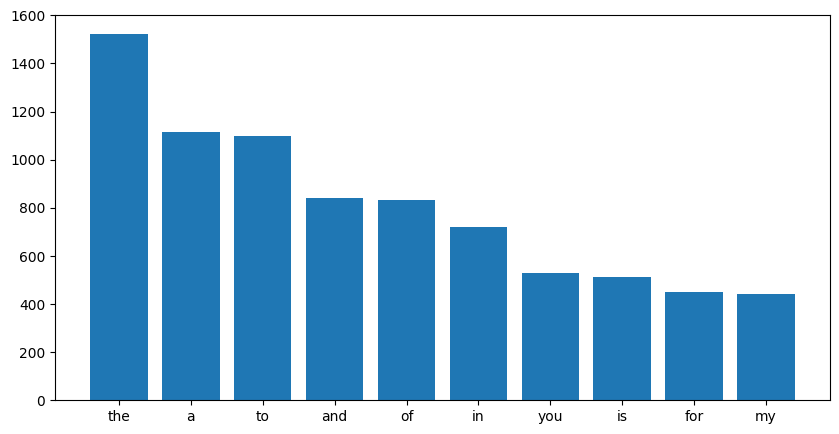

In [19]:
### COMMON STOPWORDS IN NON-DISASTER TWEETS ###
disp_top(n_top)

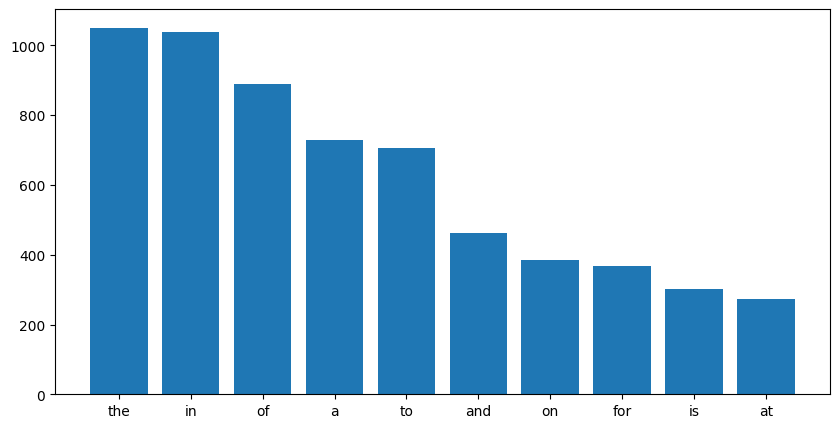

In [20]:
### COMMON STOPWORDS IN DISASTER TWEETS ###
disp_top(p_top)

In [21]:
### CREATING PREPROCESSING METHODS ###
def include_word_count(input_df): # Addition of word_count metafeature, containing word count for each tweet
    wc = 0
    input_df['total_words'] = [len(x.split()) for x in input_df['text'].tolist()]
    pass

def include_unique_word_count(input_df): # Addition of unique_word_count metafeature
    input_df['unique_words'] = [len(set(x.split())) for x in input_df['text'].str.lower()]
    pass

def include_char_count(input_df): # Addition of char_count metafeature
    input_df['total_chars'] = input_df['text'].str.len()
    pass

def include_mean_word_length(input_df): # Addition of mean_word_length metafeature
    input_df['avg_length'] = input_df["text"].apply(lambda x: len(x.split()))
    pass

In [ ]:
### PREPROCESSING METHODS FOR DATA CLEANING ###

def remove_URLs(input_df):
    input_df = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", input_df)
    pass

def remove_punctuation(input_df):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        input_df = input_df.replace(p, f' {p} ')
    input_df = input_df.replace('...', ' ... ')
    if '...' not in input_df:
        input_df = input_df.replace('..', ' ... ')
    pass

def remove_contractions(input_df):
    input_df = re.sub(r"he's", "he is", input_df)
    input_df = re.sub(r"there's", "there is", input_df)
    input_df = re.sub(r"We're", "We are", input_df)
    input_df = re.sub(r"That's", "That is", input_df)
    input_df = re.sub(r"won't", "will not", input_df)
    input_df = re.sub(r"they're", "they are", input_df)
    input_df = re.sub(r"Can't", "Cannot", input_df)
    input_df = re.sub(r"wasn't", "was not", input_df)
    input_df = re.sub(r"don\x89Ûªt", "do not", input_df)
    input_df = re.sub(r"aren't", "are not", input_df)
    input_df = re.sub(r"isn't", "is not", input_df)
    input_df = re.sub(r"What's", "What is", input_df)
    input_df = re.sub(r"haven't", "have not", input_df)
    input_df = re.sub(r"hasn't", "has not", input_df)
    input_df = re.sub(r"There's", "There is", input_df)
    input_df = re.sub(r"He's", "He is", input_df)
    input_df = re.sub(r"It's", "It is", input_df)
    input_df = re.sub(r"You're", "You are", input_df)
    input_df = re.sub(r"I'M", "I am", input_df)
    input_df = re.sub(r"shouldn't", "should not", input_df)
    input_df = re.sub(r"wouldn't", "would not", input_df)
    input_df = re.sub(r"i'm", "I am", input_df)
    input_df = re.sub(r"I\x89Ûªm", "I am", input_df)
    input_df = re.sub(r"I'm", "I am", input_df)
    input_df = re.sub(r"Isn't", "is not", input_df)
    input_df = re.sub(r"Here's", "Here is", input_df)
    input_df = re.sub(r"you've", "you have", input_df)
    input_df = re.sub(r"you\x89Ûªve", "you have", input_df)
    input_df = re.sub(r"we're", "we are", input_df)
    input_df = re.sub(r"what's", "what is", input_df)
    input_df = re.sub(r"couldn't", "could not", input_df)
    input_df = re.sub(r"we've", "we have", input_df)
    input_df = re.sub(r"it\x89Ûªs", "it is", input_df)
    input_df = re.sub(r"doesn\x89Ûªt", "does not", input_df)
    input_df = re.sub(r"It\x89Ûªs", "It is", input_df)
    input_df = re.sub(r"Here\x89Ûªs", "Here is", input_df)
    input_df = re.sub(r"who's", "who is", input_df)
    input_df = re.sub(r"I\x89Ûªve", "I have", input_df)
    input_df = re.sub(r"y'all", "you all", input_df)
    input_df = re.sub(r"can\x89Ûªt", "cannot", input_df)
    input_df = re.sub(r"would've", "would have", input_df)
    input_df = re.sub(r"it'll", "it will", input_df)
    input_df = re.sub(r"we'll", "we will", input_df)
    input_df = re.sub(r"wouldn\x89Ûªt", "would not", input_df)
    input_df = re.sub(r"We've", "We have", input_df)
    input_df = re.sub(r"he'll", "he will", input_df)
    input_df = re.sub(r"Y'all", "You all", input_df)
    input_df = re.sub(r"Weren't", "Were not", input_df)
    input_df = re.sub(r"Didn't", "Did not", input_df)
    input_df = re.sub(r"they'll", "they will", input_df)
    input_df = re.sub(r"they'd", "they would", input_df)
    input_df = re.sub(r"DON'T", "DO NOT", input_df)
    input_df = re.sub(r"That\x89Ûªs", "That is", input_df)
    input_df = re.sub(r"they've", "they have", input_df)
    input_df = re.sub(r"i'd", "I would", input_df)
    input_df = re.sub(r"should've", "should have", input_df)
    input_df = re.sub(r"You\x89Ûªre", "You are", input_df)
    input_df = re.sub(r"where's", "where is", input_df)
    input_df = re.sub(r"Don\x89Ûªt", "Do not", input_df)
    input_df = re.sub(r"we'd", "we would", input_df)
    input_df = re.sub(r"i'll", "I will", input_df)
    input_df = re.sub(r"weren't", "were not", input_df)
    input_df = re.sub(r"They're", "They are", input_df)
    input_df = re.sub(r"Can\x89Ûªt", "Cannot", input_df)
    input_df = re.sub(r"you\x89Ûªll", "you will", input_df)
    input_df = re.sub(r"I\x89Ûªd", "I would", input_df)
    input_df = re.sub(r"let's", "let us", input_df)
    input_df = re.sub(r"it's", "it is", input_df)
    input_df = re.sub(r"can't", "cannot", input_df)
    input_df = re.sub(r"don't", "do not", input_df)
    input_df = re.sub(r"you're", "you are", input_df)
    input_df = re.sub(r"i've", "I have", input_df)
    input_df = re.sub(r"that's", "that is", input_df)
    input_df = re.sub(r"i'll", "I will", input_df)
    input_df = re.sub(r"doesn't", "does not", input_df)
    input_df = re.sub(r"i'd", "I would", input_df)
    input_df = re.sub(r"didn't", "did not", input_df)
    input_df = re.sub(r"ain't", "am not", input_df)
    input_df = re.sub(r"you'll", "you will", input_df)
    input_df = re.sub(r"I've", "I have", input_df)
    input_df = re.sub(r"Don't", "do not", input_df)
    input_df = re.sub(r"I'll", "I will", input_df)
    input_df = re.sub(r"I'd", "I would", input_df)
    input_df = re.sub(r"Let's", "Let us", input_df)
    input_df = re.sub(r"you'd", "You would", input_df)
    input_df = re.sub(r"It's", "It is", input_df)
    input_df = re.sub(r"Ain't", "am not", input_df)
    input_df = re.sub(r"Haven't", "Have not", input_df)
    input_df = re.sub(r"Could've", "Could have", input_df)
    input_df = re.sub(r"youve", "you have", input_df)  
    input_df = re.sub(r"donå«t", "do not", input_df)

def remove_special_characters(input_df):
    input_df = re.sub(r"\x89Û_", "", input_df)
    input_df = re.sub(r"\x89ÛÒ", "", input_df)
    input_df = re.sub(r"\x89ÛÓ", "", input_df)
    input_df = re.sub(r"\x89ÛÏWhen", "When", input_df)
    input_df = re.sub(r"\x89ÛÏ", "", input_df)
    input_df = re.sub(r"China\x89Ûªs", "China's", input_df)
    input_df = re.sub(r"let\x89Ûªs", "let's", input_df)
    input_df = re.sub(r"\x89Û÷", "", input_df)
    input_df = re.sub(r"\x89Ûª", "", input_df)
    input_df = re.sub(r"\x89Û\x9d", "", input_df)
    input_df = re.sub(r"å_", "", input_df)
    input_df = re.sub(r"\x89Û¢", "", input_df)
    input_df = re.sub(r"\x89Û¢åÊ", "", input_df)
    input_df = re.sub(r"fromåÊwounds", "from wounds", input_df)
    input_df = re.sub(r"åÊ", "", input_df)
    input_df = re.sub(r"åÈ", "", input_df)
    input_df = re.sub(r"JapÌ_n", "Japan", input_df)    
    input_df = re.sub(r"Ì©", "e", input_df)
    input_df = re.sub(r"å¨", "", input_df)
    input_df = re.sub(r"SuruÌ¤", "Suruc", input_df)
    input_df = re.sub(r"åÇ", "", input_df)
    input_df = re.sub(r"å£3million", "3 million", input_df)
    input_df = re.sub(r"åÀ", "", input_df)

    input_df = re.sub(r"&gt;", ">", input_df)
    input_df = re.sub(r"&lt;", "<", input_df)
    input_df = re.sub(r"&amp;", "&", input_df)
    pass


In [ ]:
### FEATURE IMPORTANCE ###
def feature_importance(input_df):
    pass

In [ ]:
### REMOVAL OF UNNECESSARY FEATURES ###


### Model Building

In [ ]:
### CREATING ESSENTIAL CLASSES AND FUNCTIONS ###

### Model Evaluation

In [ ]:
### ANALYZING HYPERPARAMETER VALUES AND BEHAVIOUR ###

### Results and Conclusion

In [ ]:
### OPTIMAL MODEL ###

In [ ]:
### OPTIMAL RESULTS ###

In [ ]:
### SUBMISSION SCRIPT ###

[Jump to top](#analysis-of-natural-language-processing-with-disaster-tweets-competition)